# <h1><b><I> General Setup

## Imports and general setup

In [1]:
import os, sys, time
from tqdm import tqdm
sys.path.append("gammabayes/BFCalc/")
sys.path.append("gammabayes")

# from gammabayes.BFCalc.createspectragrids import singlechannel_diffflux, getspectrafunc, darkmatterdoubleinput, energymassinputspectralfunc
from gammabayes.likelihoods.instrument_response_funcs import log_bkg_CCR_dist, log_edisp, log_psf, single_loglikelihood
from scipy import interpolate, special, integrate
from gammabayes.utils.event_axes import log10eaxistrue, longitudeaxistrue, latitudeaxistrue, log10eaxis, longitudeaxis, latitudeaxis
# from gammabayes.utils.utils import inverse_transform_sampling
from gammabayes.hyper_inference.hyperparameter_likelihood import hyperparameter_likelihood
from gammabayes.priors.prior import discrete_logprior
from gammabayes.likelihoods.likelihood import discrete_loglikelihood
from gammabayes.dark_matter.SS_DM_Constructor import SS_DM_dist
from gammabayes.utils.utils import convertlonlat_to_offset, bin_centres_to_edges


import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from astropy import units as u
from scipy import special,stats
from scipy.integrate import simps
from matplotlib import cm
from tqdm.autonotebook import tqdm as notebook_tqdm

import functools, random
from multiprocessing import Pool, freeze_support
import multiprocessing
import pandas as pd

random.seed(0)


/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from scipy import stats

sigma_to_percentage = lambda sigma: stats.norm.cdf(sigma)-stats.norm.cdf(-sigma)

In [3]:
diffuse_astrophysicalbackground = np.load("gammabayes/package_data/unnormalised_astrophysical_diffuse_background.npy")
point_astrophysicalbackground = np.load("gammabayes/package_data/unnormalised_astrophysical_point_background.npy")
psfnormalisationvalues = np.load("gammabayes/package_data/psfnormalisation.npy")
edispnormalisationvalues = np.load("gammabayes/package_data/edispnormalisation.npy")


In [4]:
log10emeshtrue, lonmeshtrue, latmeshtrue = np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')
lonmeshrecon, latmeshrecon = np.meshgrid(longitudeaxis, latitudeaxis, indexing='ij')

logjacobtrue = np.meshgrid(np.log(10**log10eaxistrue), longitudeaxistrue, latitudeaxistrue, indexing='ij')[0]


print(lonmeshtrue.shape, lonmeshrecon.shape)

(301, 35, 30) (35, 30)


## Script Parameter Setup

In [5]:
numberoftruevaluesamples = int(2e2)
Nsamples=numberoftruevaluesamples
sigfraction                 = 0.25
ccr_of_bkg_fraction         = 0.33
diffuse_of_astro_fraction   = 0.5
nsig                        = int(round(sigfraction*Nsamples))
nastrodiffuse               = int(round((1-sigfraction)*(1-ccr_of_bkg_fraction)*diffuse_of_astro_fraction*Nsamples))
nastropoint                 =int(round((1-sigfraction)*(1-ccr_of_bkg_fraction)*(1-diffuse_of_astro_fraction)*Nsamples))
nccr                        = int(round((1-sigfraction)*ccr_of_bkg_fraction*Nsamples))

numcores            = 8
truelogmass         = 0.51

startertimer = time.perf_counter()
print(startertimer)

3.495997667


# <h1><b>Simulation

## Setup

### Diffuse Astro Background setup

In [6]:
unnormed_log_diffuse_astrobkgpriorvalues = np.log(diffuse_astrophysicalbackground)

log_astro_diffuse_bkgpriorvalues = unnormed_log_diffuse_astrobkgpriorvalues - special.logsumexp(unnormed_log_diffuse_astrobkgpriorvalues+logjacobtrue)




log_bkgastro_diffuse = interpolate.RegularGridInterpolator((log10eaxistrue, longitudeaxistrue, latitudeaxistrue), np.exp(log_astro_diffuse_bkgpriorvalues))
log_diffuse_astro_bkgfunc = lambda logenergy, longitude, latitude: np.log(log_bkgastro_diffuse((logenergy, longitude, latitude)))


diffuse_astro_bkg_prior = discrete_logprior(logfunction=log_diffuse_astro_bkgfunc, name='Diffuse Astrophysical Background Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), 
                               axes_names=['energy', 'lon', 'lat'], logjacob=logjacobtrue)



In [7]:
unnormed_log_point_astrobkgpriorvalues = np.log(point_astrophysicalbackground)

log_astro_point_bkgpriorvalues = unnormed_log_point_astrobkgpriorvalues - special.logsumexp(unnormed_log_point_astrobkgpriorvalues+logjacobtrue)




log_bkgastro_point = interpolate.RegularGridInterpolator((log10eaxistrue, longitudeaxistrue, latitudeaxistrue), np.exp(log_astro_point_bkgpriorvalues))
log_point_astro_bkgfunc = lambda logenergy, longitude, latitude: np.log(log_bkgastro_point((logenergy, longitude, latitude)))


point_astro_bkg_prior = discrete_logprior(logfunction=log_point_astro_bkgfunc, name='Point Source Astrophysical Background Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), 
                               axes_names=['energy', 'lon', 'lat'], logjacob=logjacobtrue)



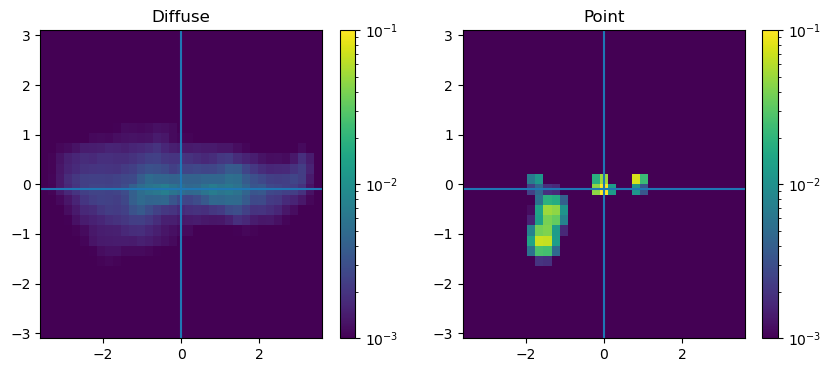

In [8]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('Diffuse')
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, np.exp(special.logsumexp(log_astro_diffuse_bkgpriorvalues+logjacobtrue, axis=0)).T,
               norm=LogNorm(vmin=1e-3, vmax=1e-1))
lonmesh, latmesh = np.meshgrid(longitudeaxistrue, latitudeaxistrue, indexing='ij')
zeroindex = convertlonlat_to_offset(np.array([lonmesh.flatten(), latmesh.flatten()])).argmin()
zeroindex_coord = np.unravel_index(zeroindex, shape=lonmesh.shape)
plt.axvline(longitudeaxistrue[zeroindex_coord[0]])
plt.axhline(latitudeaxistrue[zeroindex_coord[1]])
plt.colorbar()

plt.subplot(122)
plt.title('Point')
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, np.exp(special.logsumexp(log_astro_point_bkgpriorvalues+logjacobtrue, axis=0)).T,
               norm=LogNorm(vmin=1e-3, vmax=1e-1))
lonmesh, latmesh = np.meshgrid(longitudeaxistrue, latitudeaxistrue, indexing='ij')
zeroindex = convertlonlat_to_offset(np.array([lonmesh.flatten(), latmesh.flatten()])).argmin()
zeroindex_coord = np.unravel_index(zeroindex, shape=lonmesh.shape)
plt.axvline(longitudeaxistrue[zeroindex_coord[0]])
plt.axhline(latitudeaxistrue[zeroindex_coord[1]])
plt.colorbar()

In [9]:
ccr_bkg_prior = discrete_logprior(logfunction=log_bkg_CCR_dist, name='CCR Mis-identification Background Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), 
                               axes_names=['energy', 'lon', 'lat'], logjacob=logjacobtrue)

### Signal Setup

In [10]:
SS_DM_dist_instance= SS_DM_dist(longitudeaxistrue, latitudeaxistrue)
logDMpriorfunc = SS_DM_dist_instance.func_setup()

In [11]:
DM_prior = discrete_logprior(logfunction=logDMpriorfunc, name='Scalar Singlet Dark Matter Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), axes_names=['energy', 'lon', 'lat'],
                               default_hyperparameter_values=(truelogmass,), hyperparameter_names=['mass'], logjacob=logjacobtrue)
DM_prior

(0.51,)


discrete log prior class
----------------------------
name = Scalar Singlet Dark Matter Prior
logfunction type is <function SS_DM_dist.func_setup.<locals>.DM_signal_dist at 0x7ff0f235af70>
input units of None
over axes ['energy', 'lon', 'lat']
with hyperparameter(s) ['mass']

## True Value Simulation

In [12]:
if nsig!=0:
    siglogevals,siglonvals,siglatvals  = DM_prior.sample(nsig)
else:
    siglogevals = np.asarray([])
    siglonvals = np.asarray([])
    siglatvals = np.asarray([])

if nccr!=0:
    ccrlogevals,ccrlonvals,ccrlatvals  = ccr_bkg_prior.sample(nccr)
else:
    ccrlogevals = np.asarray([])
    ccrlonvals = np.asarray([])
    ccrlatvals = np.asarray([])

if nastrodiffuse!=0:
    diffuse_astrologevals,diffuse_astrolonvals,diffuse_astrolatvals  = diffuse_astro_bkg_prior.sample(nastrodiffuse)
else:
    diffuse_astrologevals = np.asarray([])
    diffuse_astrolonvals = np.asarray([])
    diffuse_astrolatvals = np.asarray([])

if nastropoint!=0:
    point_astrologevals,point_astrolonvals,point_astrolatvals  = point_astro_bkg_prior.sample(nastropoint)
else:
    point_astrologevals = np.asarray([])
    point_astrolonvals = np.asarray([])
    point_astrolatvals = np.asarray([])



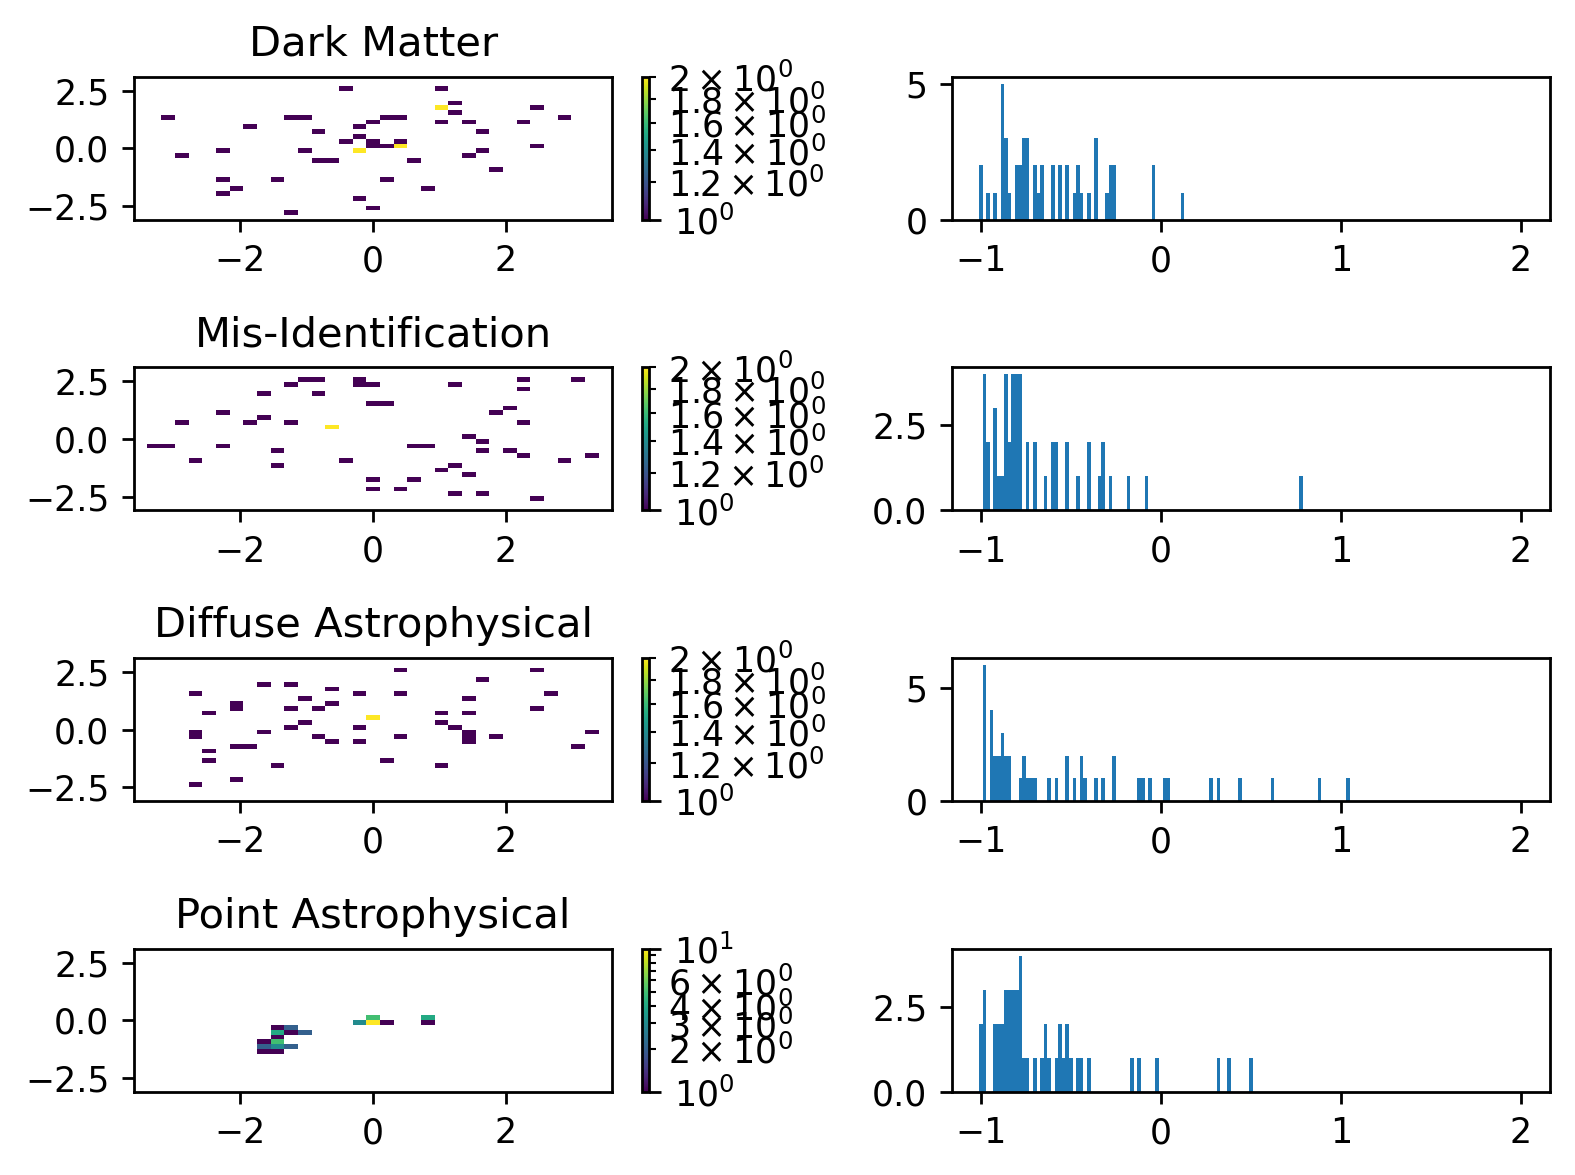

In [13]:
plt.figure(dpi=250)
plt.subplot(421)
plt.title("Dark Matter")
plt.hist2d(siglonvals,siglatvals, bins=(bin_centres_to_edges(longitudeaxistrue), bin_centres_to_edges(latitudeaxistrue)), norm=LogNorm())
plt.colorbar()

plt.subplot(422)
plt.hist(siglogevals, bins=bin_centres_to_edges(log10eaxistrue[::2]))


plt.subplot(423)
plt.title("Mis-Identification")

plt.hist2d(ccrlonvals,ccrlatvals, bins=(bin_centres_to_edges(longitudeaxistrue), bin_centres_to_edges(latitudeaxistrue)), norm=LogNorm())
plt.colorbar()


plt.subplot(424)
plt.hist(ccrlogevals, bins=bin_centres_to_edges(log10eaxistrue[::2]))


plt.subplot(425)
plt.title("Diffuse Astrophysical")
plt.hist2d(diffuse_astrolonvals,diffuse_astrolatvals, bins=(bin_centres_to_edges(longitudeaxistrue), bin_centres_to_edges(latitudeaxistrue)), norm=LogNorm())
plt.colorbar()

plt.subplot(426)
plt.hist(diffuse_astrologevals, bins=bin_centres_to_edges(log10eaxistrue[::2]))

plt.subplot(427)
plt.title("Point Astrophysical")
plt.hist2d(point_astrolonvals,point_astrolatvals, bins=(bin_centres_to_edges(longitudeaxistrue), bin_centres_to_edges(latitudeaxistrue)), norm=LogNorm())
plt.colorbar()

plt.subplot(428)
plt.hist(point_astrologevals, bins=bin_centres_to_edges(log10eaxistrue[::2]))




plt.tight_layout()
plt.show()

## Reconstructed Value Simulation

In [14]:
logjacob = np.meshgrid(np.log(10**log10eaxis), longitudeaxis, latitudeaxis, indexing='ij')[0]

In [15]:
logjacob = np.log(10**log10eaxis)
edisp_like = discrete_loglikelihood(logfunction=log_edisp, 
                                    axes=(log10eaxis,), axes_names='log10E recon',
                                    name='energy dispersion',
                                    dependent_axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), logjacob=logjacob,
                                    dependent_axes_names = ['log10E true', 'lon', 'lat'])

Number of input dimensions 1


In [16]:
psf_like = discrete_loglikelihood(logfunction=log_psf, 
                                    axes=(longitudeaxis, latitudeaxis), axes_names=['longitude recon', 'latitude recon'],
                                    name='point spread function ',
                                    dependent_axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,),
                                    dependent_axes_names = ['log10E true', 'lon', 'lat'])
psf_like

Number of input dimensions 2


discrete log likelihood class
---------------------------------
name = point spread function 
logfunction type is <function log_psf at 0x7ff0d3ba2280>
input units of None
over axes ['longitude recon', 'latitude recon']
with dependent axes ['log10E true', 'lon', 'lat']

### Signal

In [17]:
signal_lon_measured = []
signal_lat_measured = []
if nsig!=0:
    signal_log10e_measured = [np.squeeze(edisp_like.sample((logeval,*coord,), numsamples=1)) for logeval,coord  in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)]
    sig_lonlat_psf_samples =  [psf_like.sample((logeval,*coord,), 1).tolist() for logeval,coord  in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)]
    
    for sig_lonlat_psf_sample in sig_lonlat_psf_samples:
        signal_lon_measured.append(sig_lonlat_psf_sample[0])
        signal_lat_measured.append(sig_lonlat_psf_sample[1])
else:
    signal_log10e_measured = np.asarray([])

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 154.57it/s]


### Background

In [18]:
diffuse_astro_lon_measured = []
diffuse_astro_lat_measured = []
if nastrodiffuse!=0:
    diffuse_astro_log10e_measured = [np.squeeze(edisp_like.sample((logeval,*coord,), numsamples=1)) for logeval,coord  in notebook_tqdm(zip(diffuse_astrologevals, np.array([diffuse_astrolonvals, diffuse_astrolatvals]).T), total=nastrodiffuse)]
    diffuse_astro_lonlat_psf_samples =  [psf_like.sample((logeval,*coord,), 1).tolist() for logeval,coord  in notebook_tqdm(zip(diffuse_astrologevals, np.array([diffuse_astrolonvals, diffuse_astrolatvals]).T), total=nastrodiffuse)]
    
    for diffuse_astro_lonlat_psf_sample in diffuse_astro_lonlat_psf_samples:
        diffuse_astro_lon_measured.append(diffuse_astro_lonlat_psf_sample[0])
        diffuse_astro_lat_measured.append(diffuse_astro_lonlat_psf_sample[1])
else:
    diffuse_astro_log10e_measured = np.asarray([])

100%|██████████| 50/50 [00:00<00:00, 154.56it/s]


In [19]:
point_astro_lon_measured = []
point_astro_lat_measured = []
if nastrodiffuse!=0:
    point_astro_log10e_measured = [np.squeeze(edisp_like.sample((logeval,*coord,), numsamples=1)) for logeval,coord  in notebook_tqdm(zip(point_astrologevals, np.array([point_astrolonvals, point_astrolatvals]).T), total=nastropoint)]
    point_astro_lonlat_psf_samples =  [psf_like.sample((logeval,*coord,), 1).tolist() for logeval,coord  in notebook_tqdm(zip(point_astrologevals, np.array([point_astrolonvals, point_astrolatvals]).T), total=nastropoint)]
    
    for point_astro_lonlat_psf_sample in point_astro_lonlat_psf_samples:
        point_astro_lon_measured.append(point_astro_lonlat_psf_sample[0])
        point_astro_lat_measured.append(point_astro_lonlat_psf_sample[1])
else:
    point_astro_log10e_measured = np.asarray([])

100%|██████████| 50/50 [00:00<00:00, 154.54it/s]


In [20]:
ccr_lon_measured = []
ccr_lat_measured = []
if nccr!=0:
    ccr_log10e_measured = [np.squeeze(edisp_like.sample((logeval,*coord,), numsamples=1)) for logeval,coord  in notebook_tqdm(zip(ccrlogevals, np.array([ccrlonvals, ccrlatvals]).T), total=nccr)]
    ccr_lonlat_psf_samples =  [psf_like.sample((logeval,*coord,), 1).tolist() for logeval,coord  in notebook_tqdm(zip(ccrlogevals, np.array([ccrlonvals, ccrlatvals]).T), total=nccr)]
    
    for ccr_lonlat_psf_sample in ccr_lonlat_psf_samples:
        ccr_lon_measured.append(ccr_lonlat_psf_sample[0])
        ccr_lat_measured.append(ccr_lonlat_psf_sample[1])
else:
    ccr_log10e_measured = np.asarray([])

100%|██████████| 50/50 [00:00<00:00, 155.92it/s]


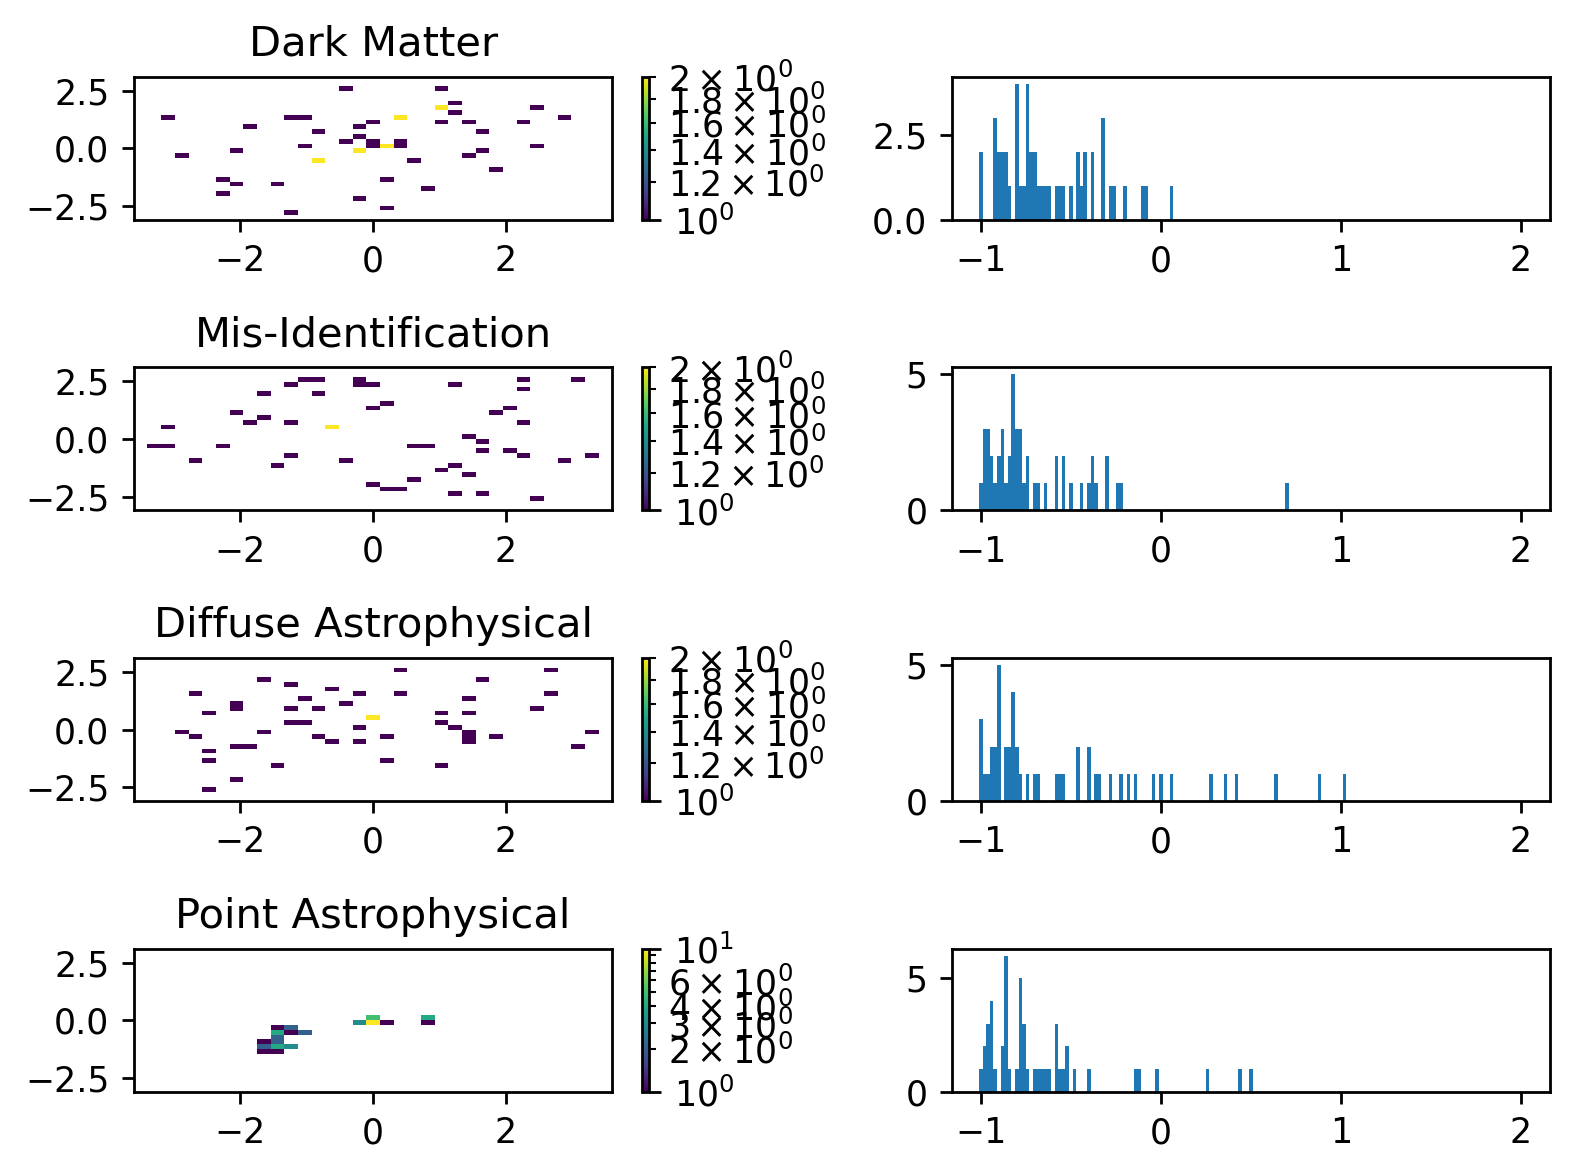

In [21]:
plt.figure(dpi=250)
plt.subplot(421)
plt.title("Dark Matter")
plt.hist2d(signal_lon_measured,signal_lat_measured, bins=(bin_centres_to_edges(longitudeaxis), bin_centres_to_edges(latitudeaxis)), norm=LogNorm())
plt.colorbar()

plt.subplot(422)
plt.hist(signal_log10e_measured, bins=bin_centres_to_edges(log10eaxis[::2]))


plt.subplot(423)
plt.title("Mis-Identification")

plt.hist2d(ccr_lon_measured, ccr_lat_measured, bins=(bin_centres_to_edges(longitudeaxis), bin_centres_to_edges(latitudeaxis)), norm=LogNorm())
plt.colorbar()


plt.subplot(424)
plt.hist(ccr_log10e_measured, bins=bin_centres_to_edges(log10eaxis[::2]))


plt.subplot(425)
plt.title("Diffuse Astrophysical")
plt.hist2d(diffuse_astro_lon_measured,diffuse_astro_lat_measured, bins=(bin_centres_to_edges(longitudeaxis), bin_centres_to_edges(latitudeaxis)), norm=LogNorm())
plt.colorbar()

plt.subplot(426)
plt.hist(diffuse_astro_log10e_measured, bins=bin_centres_to_edges(log10eaxis[::2]))

plt.subplot(427)
plt.title("Point Astrophysical")
plt.hist2d(point_astro_lon_measured,point_astro_lat_measured, bins=(bin_centres_to_edges(longitudeaxis), bin_centres_to_edges(latitudeaxis)), norm=LogNorm())
plt.colorbar()

plt.subplot(428)
plt.hist(point_astro_log10e_measured, bins=bin_centres_to_edges(log10eaxis[::2]))




plt.tight_layout()
plt.show()

## Final simulation output

In [22]:

try:
    measured_log10e = list(signal_log10e_measured)+list(diffuse_astro_log10e_measured)+list(point_astro_log10e_measured)+list(ccr_log10e_measured)
    measured_lon = list(signal_lon_measured)+list(diffuse_astro_lon_measured)+list(point_astro_lon_measured)+list(ccr_lon_measured)
    measured_lat = list(signal_lat_measured)+list(diffuse_astro_lat_measured)+list(point_astro_lat_measured)+list(ccr_lat_measured)
    
except:
    print('what')

# <h1><b>Analysis

## Marginalisation

In [23]:
nbinslogmass=41

if nsig is None:
    nsig = len(list(measured_log10e))

logmasswindowwidth      = 16/np.sqrt(nsig)

logmasslowerbound       = truelogmass-logmasswindowwidth
logmassupperbound       = truelogmass+logmasswindowwidth

# if 1:
if logmasslowerbound<log10eaxis[0]:
    logmasslowerbound = log10eaxis[0]
# if 1:
if logmassupperbound>2:
    logmassupperbound = 2


logmassrange            = np.linspace(logmasslowerbound, logmassupperbound, nbinslogmass) 

In [24]:
hyperparameter_likelihood_instance = hyperparameter_likelihood(priors=(DM_prior, ccr_bkg_prior, diffuse_astro_bkg_prior, point_astro_bkg_prior), likelihood=single_loglikelihood, 
                                                               dependent_axes=(log10eaxistrue,  longitudeaxistrue, latitudeaxistrue), dependent_logjacob=logjacobtrue,
                                                               hyperparameter_axes = ((logmassrange,), (None,), (None,), (None, )), numcores=numcores, likelihoodnormalisation = psfnormalisationvalues+edispnormalisationvalues)

measured_log10e = [float(measured_log10e_val) for measured_log10e_val in measured_log10e]
margresults = hyperparameter_likelihood_instance.nuisance_log_marginalisation(axisvals= (measured_log10e, measured_lon, measured_lat))

Setting up prior matrices: 100%|██████████| 4/4 [00:31<00:00,  7.84s/it]
Performing parallelized direct event marginalisation: 100%|██████████| 200/200 [00:00<00:00, 366314.76it/s]
/Users/lpin0002/Desktop/temporaryfolder/GammaBayes/gammabayes/likelihoods/instrument_response_funcs.py:116: RuntimeWarning: divide by zero encountered in log
  output = np.log(psffull.evaluate(energy_true=10**logetrue*u.TeV,
/Users/lpin0002/Desktop/temporaryfolder/GammaBayes/gammabayes/likelihoods/instrument_response_funcs.py:120: RuntimeWarning: divide by zero encountered in log
  output+=np.log(edispfull.evaluate(energy_true=10**logetrue*u.TeV,


In [25]:
margresultsarray = np.array(margresults)
sigmargresults = np.squeeze(np.vstack(margresultsarray[:,0])).T
ccrmargresults = np.squeeze(np.vstack(margresultsarray[:,1]))
diffuse_astromargresults = np.squeeze(np.vstack(margresultsarray[:,2]))
point_astromargresults = np.squeeze(np.vstack(margresultsarray[:,3]))

sigmargresults.shape

(41, 200)

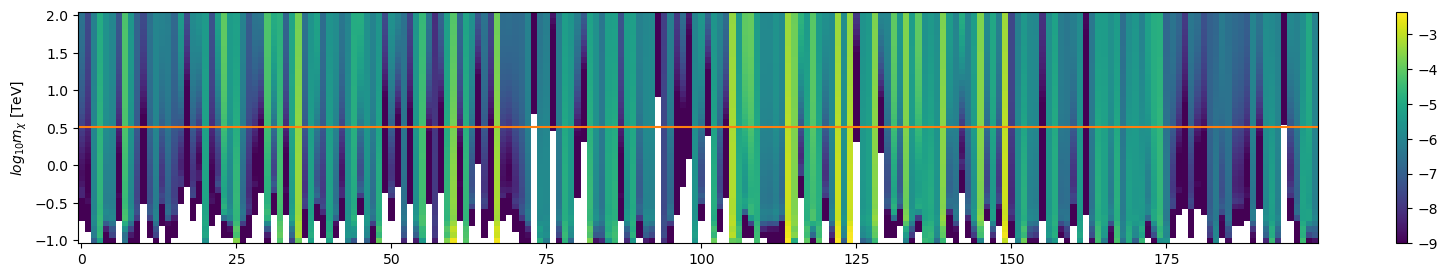

In [26]:
fig, ax = plt.subplots(figsize=(20,3))
plt.pcolormesh(*np.meshgrid(list(range(Nsamples)), logmassrange, indexing='ij'), 
               sigmargresults.T-special.logsumexp(sigmargresults, axis=1), 
               cmap='viridis', vmin=-9)
plt.ylabel(r'$log_{10}m_\chi$ [TeV]')
plt.axhline(truelogmass, c='tab:orange')
plt.colorbar()
plt.show()

## Calculating posterior

In [27]:
nbins_sigfrac               = 41
sigfrac_windowwidth         = 20/np.sqrt(Nsamples)
astrofrac_windowwidth       = 20/np.sqrt(Nsamples)

nbins_ccr_frac              = 51
nbins_diffuse_frac          = 61

sigfrac_range_upperbound = sigfraction+sigfrac_windowwidth
sigfrac_range_lowerbound = sigfraction-sigfrac_windowwidth



if sigfrac_range_upperbound>1:
    sigfrac_range_upperbound = 1
if sigfrac_range_lowerbound<0:
    sigfrac_range_lowerbound = 0

ccrfrac_of_bkg_range_upperbound = ccr_of_bkg_fraction+astrofrac_windowwidth
ccrfrac_of_bkg_range_lowerbound = ccr_of_bkg_fraction-astrofrac_windowwidth

if ccrfrac_of_bkg_range_upperbound>1:
    ccrfrac_of_bkg_range_upperbound = 1
if ccrfrac_of_bkg_range_lowerbound<0:
    ccrfrac_of_bkg_range_lowerbound = 0

diffusefrac_of_astro_range_upperbound = diffuse_of_astro_fraction+astrofrac_windowwidth
diffusefrac_of_astro_range_lowerbound = diffuse_of_astro_fraction-astrofrac_windowwidth


if diffusefrac_of_astro_range_upperbound>1:
    diffusefrac_of_astro_range_upperbound = 1
if diffusefrac_of_astro_range_lowerbound<0:
    diffusefrac_of_astro_range_lowerbound = 0


sigfracrange = np.linspace(sigfrac_range_lowerbound,    sigfrac_range_upperbound,   nbins_sigfrac)
ccrfrac_of_bkg_range = np.linspace(ccrfrac_of_bkg_range_lowerbound,diffusefrac_of_astro_range_upperbound, nbins_ccr_frac)
diffuse_of_astro_range = np.linspace(diffusefrac_of_astro_range_lowerbound,ccrfrac_of_bkg_range_upperbound, nbins_diffuse_frac)

mixtureaxes = sigfracrange, ccrfrac_of_bkg_range, diffuse_of_astro_range
    
new_log_posterior = hyperparameter_likelihood_instance.create_mixture_log_hyper_likelihood(
    mixture_axes=(*mixtureaxes,), log_margresults=margresultsarray)

new_log_posterior = new_log_posterior - special.logsumexp(new_log_posterior)

endertimer = time.perf_counter()


Reshaped mixture shape: (200, 4)
(200, 41, 51, 61, 41, 1, 1, 1)


In [28]:
# log_posterior=np.squeeze(new_log_posterior)
log_posterior = np.squeeze(new_log_posterior)
log_posterior.shape
log_posterior[0]

array([[[-6648.40625624, -6648.40625624, -6648.40625624, ...,
         -6648.40625624, -6648.40625624, -6648.40625624],
        [ -471.24567682,  -471.24567682,  -471.24567682, ...,
          -471.24567682,  -471.24567682,  -471.24567682],
        [ -382.40836745,  -382.40836745,  -382.40836745, ...,
          -382.40836745,  -382.40836745,  -382.40836745],
        ...,
        [  -62.03738246,   -62.03738246,   -62.03738246, ...,
           -62.03738246,   -62.03738246,   -62.03738246],
        [  -70.91198069,   -70.91198069,   -70.91198069, ...,
           -70.91198069,   -70.91198069,   -70.91198069],
        [  -84.11618373,   -84.11618373,   -84.11618373, ...,
           -84.11618373,   -84.11618373,   -84.11618373]],

       [[ -435.87013495,  -435.87013495,  -435.87013495, ...,
          -435.87013495,  -435.87013495,  -435.87013495],
        [ -348.35622145,  -348.35622145,  -348.35622145, ...,
          -348.35622145,  -348.35622145,  -348.35622145],
        [ -304.11088335, 

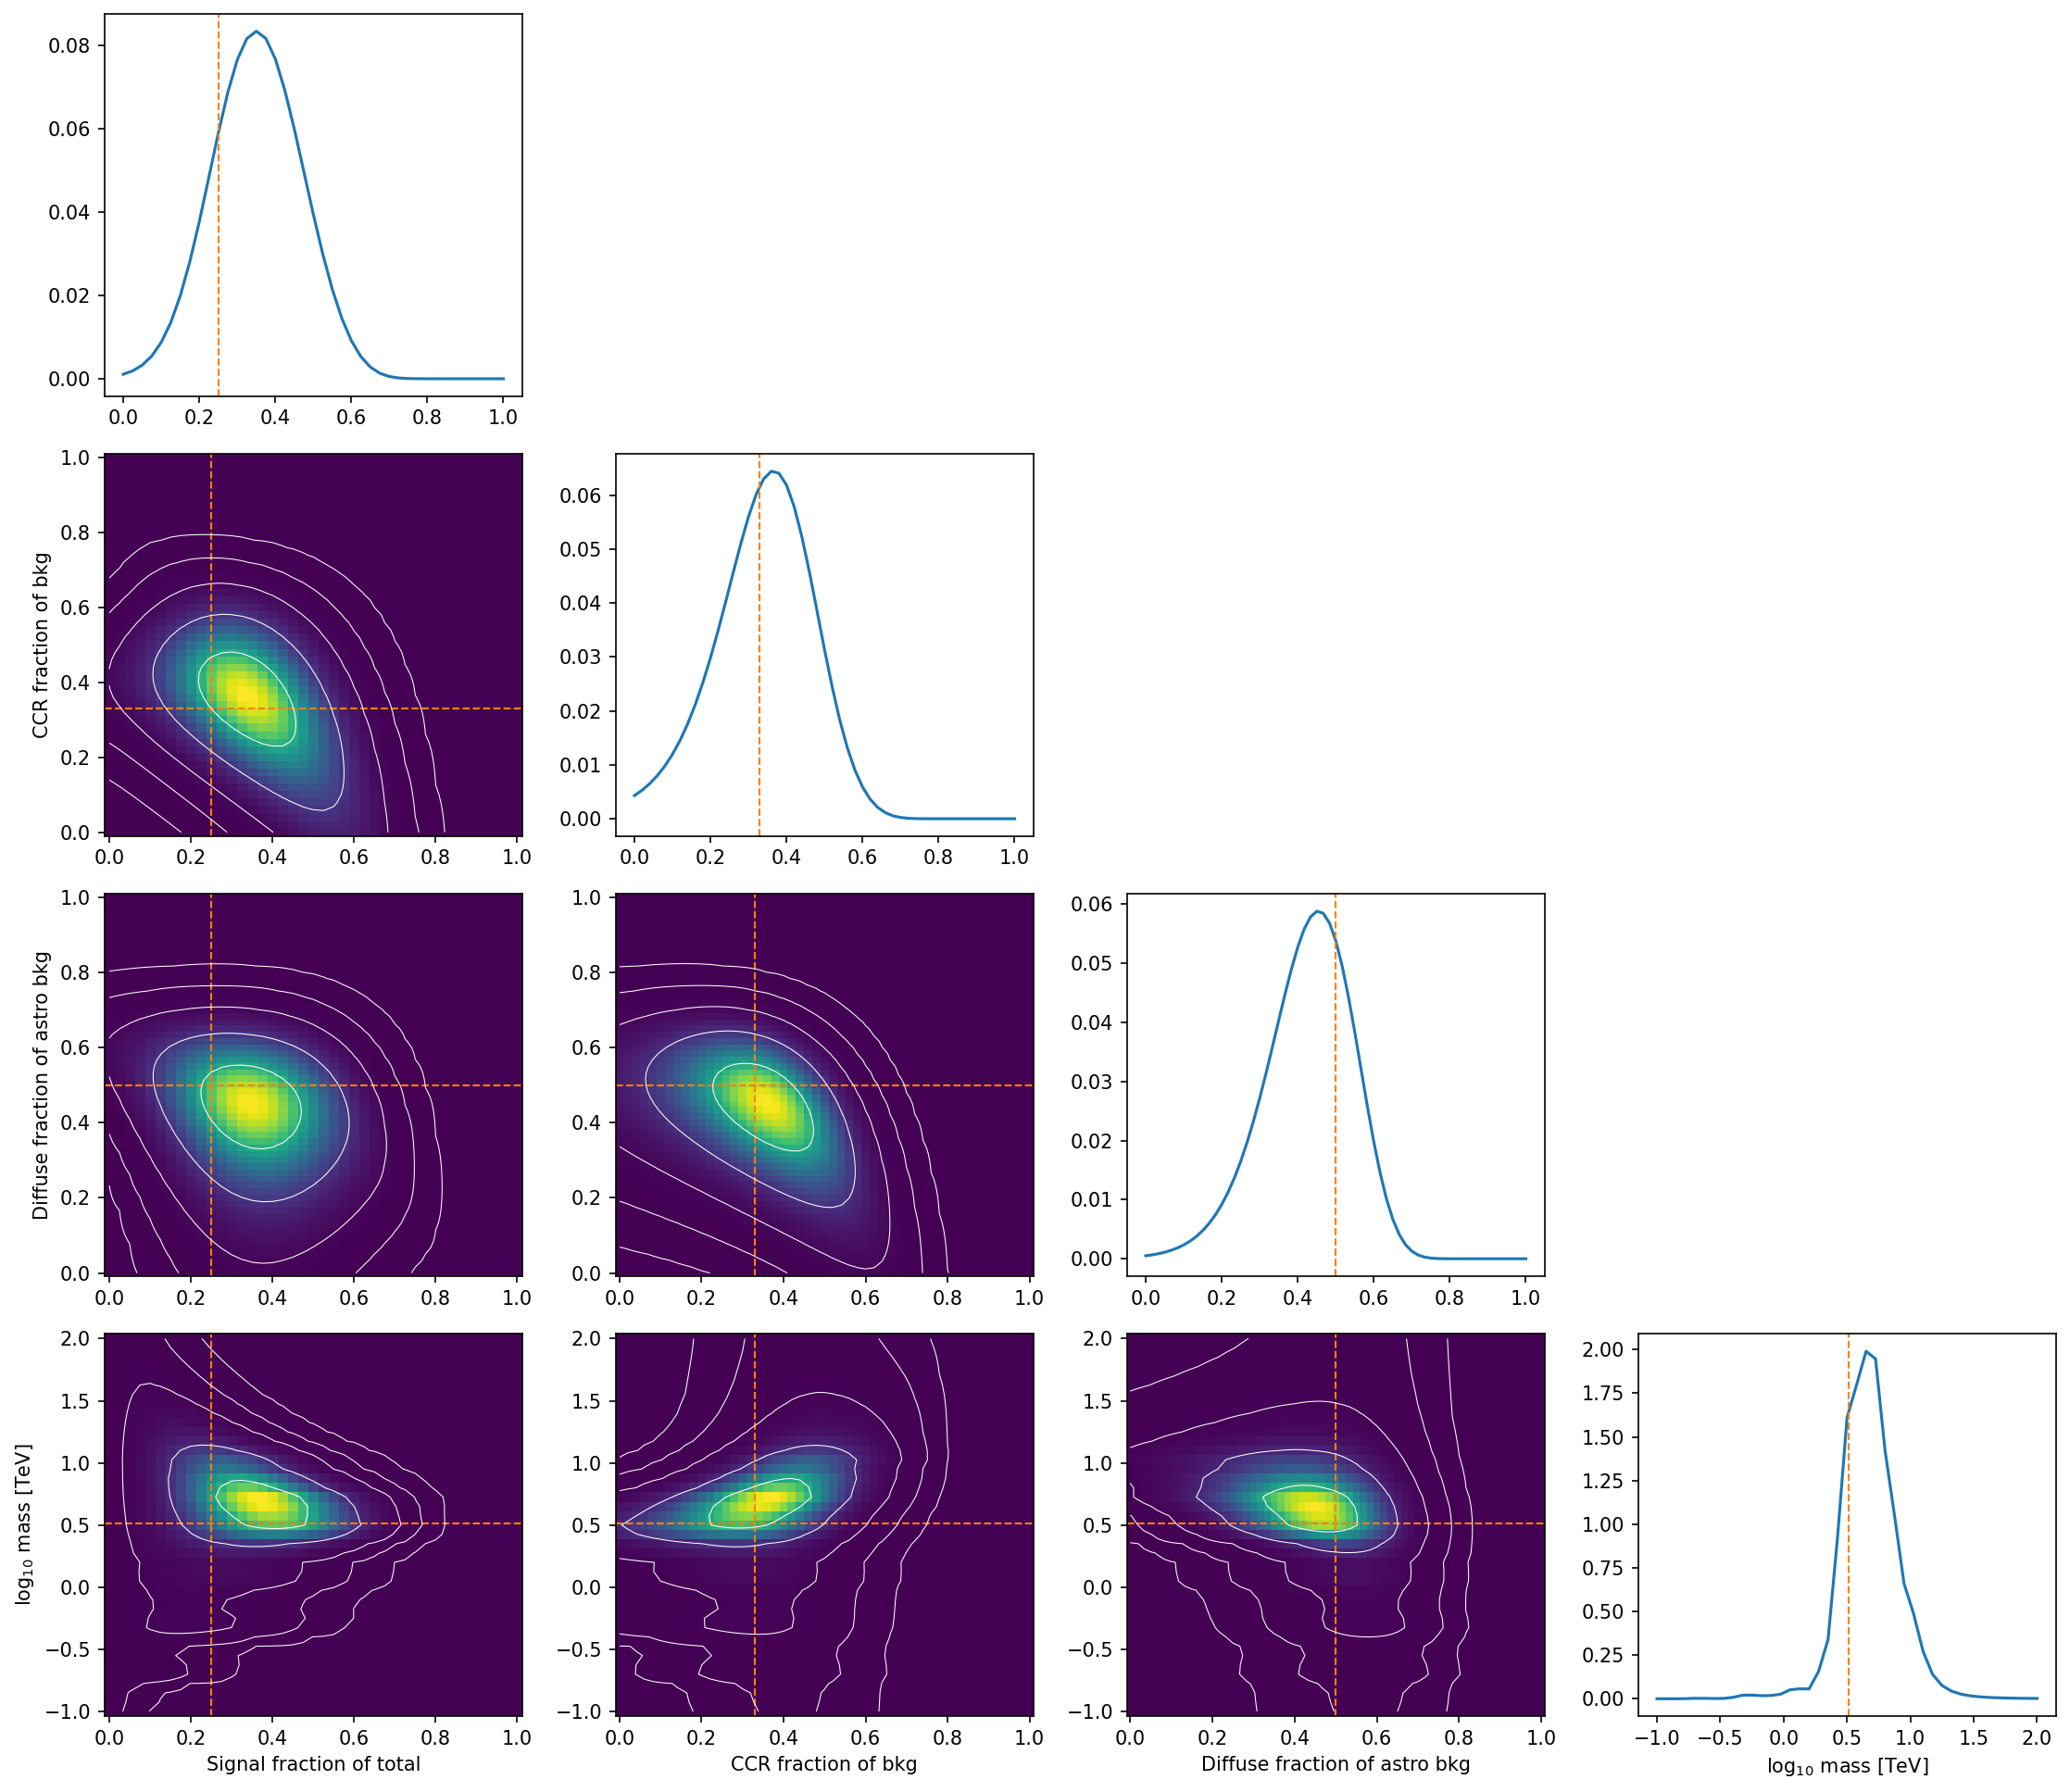

In [32]:
from scipy.integrate import cumtrapz, simps
from scipy import interpolate

zscores = list(range(-5,6))
levels = np.array([1-np.exp(-25/2), 1-np.exp(-8), 1-np.exp(-4.5),1-np.exp(-2.0),1-np.exp(-0.5)])
# 
# levels = np.array([1-np.exp(-4.5),1-np.exp(-2.0),1-np.exp(-0.5)])

percentages = stats.norm.cdf(zscores)
cmap = plt.get_cmap('Blues')

percentile_idx_calc = lambda percentile, probarray, axis: (np.where(cumtrapz(y=probarray, x=axis)<=percentile))[0][-1]




plt.figure(figsize=(15,13),dpi=150)

plt.subplot(4,4,1)
sigfrac_posterior = np.exp(special.logsumexp(log_posterior, axis=(1,2,3))) 
plt.plot(sigfracrange, sigfrac_posterior)
plt.axvline(sigfraction, c='tab:orange', ls='--', lw=1.0)


plt.subplot(442)
plt.axis('off')


plt.subplot(4,4,5)
sigfrac_ccrfrac_posterior = np.exp(special.logsumexp(log_posterior, axis=(2,3)))
plt.pcolormesh(sigfracrange, ccrfrac_of_bkg_range, sigfrac_ccrfrac_posterior.T)
plt.axvline(sigfraction, c='tab:orange', ls='--', lw=1.0)
plt.axhline(ccr_of_bkg_fraction, c='tab:orange', ls='--', lw=1.0)
plt.ylabel('CCR fraction of bkg')
########################################################################################################################
########################################################################################################################
normed_sigfrac_ccrfrac_posterior = (sigfrac_ccrfrac_posterior/sigfrac_ccrfrac_posterior.sum()).T
n = 1000
t = np.linspace(0, normed_sigfrac_ccrfrac_posterior.max(), n)
integral = ((normed_sigfrac_ccrfrac_posterior >= t[:, None, None]) * normed_sigfrac_ccrfrac_posterior).sum(axis=(1,2))

f = interpolate.interp1d(integral, t)
t_contours = f(levels)
plt.contour(normed_sigfrac_ccrfrac_posterior, t_contours, extent=[sigfracrange[0],sigfracrange[-1], ccrfrac_of_bkg_range[0],ccrfrac_of_bkg_range[-1],], colors='white', linewidths=0.5)
########################################################################################################################
########################################################################################################################




plt.subplot(4,4,6)
ccrfrac_posterior = np.exp(special.logsumexp(log_posterior, axis=(0,2,3))) 
plt.plot(ccrfrac_of_bkg_range, ccrfrac_posterior)
plt.axvline(ccr_of_bkg_fraction, c='tab:orange', ls='--', lw=1.0)





plt.subplot(4,4,9)
sigfrac_diffuse_frac_posterior = np.exp(special.logsumexp(log_posterior, axis=(1,3)))
plt.pcolormesh(sigfracrange, diffuse_of_astro_range,  sigfrac_diffuse_frac_posterior.T)
plt.axvline(sigfraction, c='tab:orange', ls='--', lw=1.0)
plt.axhline(diffuse_of_astro_fraction, c='tab:orange', ls='--', lw=1.0)
plt.ylabel('Diffuse fraction of astro bkg')

########################################################################################################################
########################################################################################################################
normed_sigfrac_diffuse_frac_posterior = (sigfrac_diffuse_frac_posterior/sigfrac_diffuse_frac_posterior.sum()).T
n = 1000
t = np.linspace(0, normed_sigfrac_diffuse_frac_posterior.max(), n)
integral = ((normed_sigfrac_diffuse_frac_posterior >= t[:, None, None]) * normed_sigfrac_diffuse_frac_posterior).sum(axis=(1,2))

f = interpolate.interp1d(integral, t)
t_contours = f(levels)
plt.contour(normed_sigfrac_diffuse_frac_posterior, t_contours, extent=[sigfracrange[0],sigfracrange[-1], diffuse_of_astro_range[0],diffuse_of_astro_range[-1],], colors='white', linewidths=0.5)
########################################################################################################################
########################################################################################################################



plt.subplot(4,4,10)
ccrfrac_diffusefrac_posterior = np.exp(special.logsumexp(log_posterior, axis=(0,3)))
plt.pcolormesh(ccrfrac_of_bkg_range, diffuse_of_astro_range, ccrfrac_diffusefrac_posterior.T )
plt.axvline(ccr_of_bkg_fraction, c='tab:orange', ls='--', lw=1.0)
plt.axhline(diffuse_of_astro_fraction, c='tab:orange', ls='--', lw=1.0)

########################################################################################################################
########################################################################################################################
normed_ccrfrac_diffusefrac_posterior = (ccrfrac_diffusefrac_posterior/ccrfrac_diffusefrac_posterior.sum()).T
n = 1000
t = np.linspace(0, normed_ccrfrac_diffusefrac_posterior.max(), n)
integral = ((normed_ccrfrac_diffusefrac_posterior >= t[:, None, None]) * normed_ccrfrac_diffusefrac_posterior).sum(axis=(1,2))

f = interpolate.interp1d(integral, t)
t_contours = f(levels)
plt.contour(normed_ccrfrac_diffusefrac_posterior, t_contours, extent=[ccrfrac_of_bkg_range[0],ccrfrac_of_bkg_range[-1], diffuse_of_astro_range[0],diffuse_of_astro_range[-1],], colors='white', linewidths=0.5)
########################################################################################################################
########################################################################################################################



plt.subplot(4,4,11)
diffusefrac_posterior = np.exp(special.logsumexp(log_posterior, axis=(0,1,3))) 

plt.plot(diffuse_of_astro_range, diffusefrac_posterior)
plt.axvline(diffuse_of_astro_fraction, c='tab:orange', ls='--', lw=1.0)


plt.subplot(4,4,13)
sigfrac_logmass_posterior = np.exp(special.logsumexp(log_posterior, axis=(1,2)))

plt.pcolormesh(sigfracrange, logmassrange, sigfrac_logmass_posterior.T )
plt.axvline(sigfraction, c='tab:orange', ls='--', lw=1.0)
plt.axhline(truelogmass, c='tab:orange', ls='--', lw=1.0)
plt.ylabel(r'log$_{10}$ mass [TeV]')
plt.xlabel('Signal fraction of total')

########################################################################################################################
########################################################################################################################
normed_sigfrac_logmass_posterior = (sigfrac_logmass_posterior/sigfrac_logmass_posterior.sum()).T
n = 1000
t = np.linspace(0, normed_sigfrac_logmass_posterior.max(), n)
integral = ((normed_sigfrac_logmass_posterior >= t[:, None, None]) * normed_sigfrac_logmass_posterior).sum(axis=(1,2))

from scipy import interpolate
f = interpolate.interp1d(integral, t)
t_contours = f(levels)
plt.contour(normed_sigfrac_logmass_posterior, t_contours, extent=[sigfracrange[0],sigfracrange[-1], logmassrange[0],logmassrange[-1], ], colors='white', linewidths=0.5)
########################################################################################################################
########################################################################################################################



plt.subplot(4,4,14)
ccrfrac_logmass_posterior = np.exp(special.logsumexp(log_posterior, axis=(0,2)))
plt.pcolormesh(ccrfrac_of_bkg_range, logmassrange, ccrfrac_logmass_posterior.T )
plt.axvline(ccr_of_bkg_fraction, c='tab:orange', ls='--', lw=1.0)
plt.axhline(truelogmass, c='tab:orange', ls='--', lw=1.0)
plt.xlabel('CCR fraction of bkg')

########################################################################################################################
########################################################################################################################
normed_ccrfrac_logmass_posterior = (ccrfrac_logmass_posterior/ccrfrac_logmass_posterior.sum()).T
n = 1000
t = np.linspace(0, normed_ccrfrac_logmass_posterior.max(), n)
integral = ((normed_ccrfrac_logmass_posterior >= t[:, None, None]) * normed_ccrfrac_logmass_posterior).sum(axis=(1,2))

f = interpolate.interp1d(integral, t)
t_contours = f(levels)
plt.contour(normed_ccrfrac_logmass_posterior, t_contours, extent=[ccrfrac_of_bkg_range[0],ccrfrac_of_bkg_range[-1], logmassrange[0],logmassrange[-1],], colors='white', linewidths=0.5)
########################################################################################################################
########################################################################################################################



plt.subplot(4,4,15)
diffuseastro_logmass_posterior = np.exp(special.logsumexp(log_posterior, axis=(0,1)))
plt.pcolormesh(diffuse_of_astro_range, logmassrange, diffuseastro_logmass_posterior.T )
plt.axvline(diffuse_of_astro_fraction, c='tab:orange', ls='--', lw=1.0)
plt.axhline(truelogmass, c='tab:orange', ls='--', lw=1.0)
plt.xlabel('Diffuse fraction of astro bkg')

########################################################################################################################
########################################################################################################################
normed_diffuseastro_logmass_posterior = (diffuseastro_logmass_posterior/diffuseastro_logmass_posterior.sum()).T
n = 1000
t = np.linspace(0, normed_diffuseastro_logmass_posterior.max(), n)
integral = ((normed_diffuseastro_logmass_posterior >= t[:, None, None]) * normed_diffuseastro_logmass_posterior).sum(axis=(1,2))

f = interpolate.interp1d(integral, t)
t_contours = f(levels)
plt.contour(normed_diffuseastro_logmass_posterior, t_contours, extent=[diffuse_of_astro_range[0],diffuse_of_astro_range[-1], logmassrange[0],logmassrange[-1],], colors='white', linewidths=0.5)
########################################################################################################################
########################################################################################################################




plt.subplot(4,4,16)
logmass_posterior = np.exp(special.logsumexp(log_posterior, axis=(0,1,2))) 
logmass_posterior = logmass_posterior/simps(y=logmass_posterior, x=logmassrange)

plt.plot(logmassrange, logmass_posterior)
plt.axvline(truelogmass, c='tab:orange', ls='--', lw=1.0)

plt.xlabel(r'log$_{10}$ mass [TeV]')

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


triggered


NameError: name 'astrofracrange' is not defined

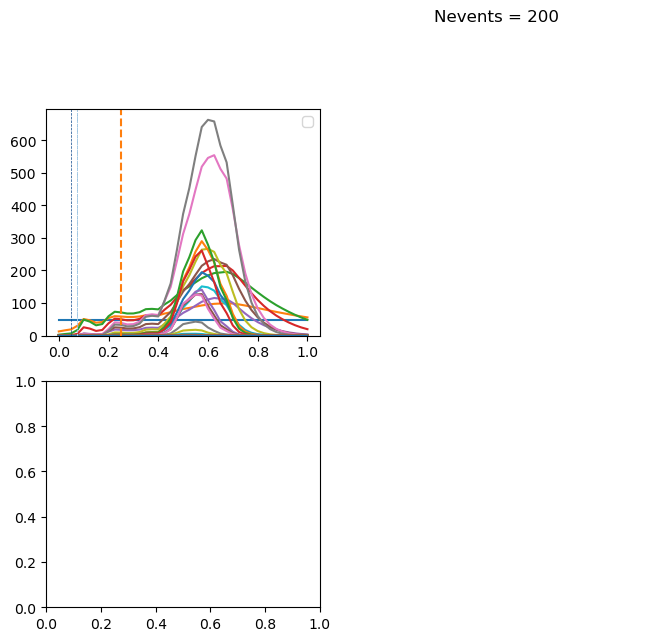

In [30]:
from scipy.integrate import cumtrapz, simps
zscores = list(range(-5,6))
levels = np.array([1-np.exp(-25/2), 1-np.exp(-8), 1-np.exp(-4.5),1-np.exp(-2.0),1-np.exp(-0.5)])
percentages = stats.norm.cdf(zscores)
cmap = plt.get_cmap('Blues')

percentile_idx_calc = lambda percentile, probarray, axis: (np.where(cumtrapz(y=probarray, x=axis)<=percentile))[0][-1]


plt.figure(figsize=(12,10))
plt.suptitle(f"Nevents = {Nsamples}")
plt.subplot(331)
sigfrac_marged = np.exp(special.logsumexp(log_posterior, axis=(1,2)).T)
sigfrac_marged = sigfrac_marged/simps(y=sigfrac_marged, x=sigfracrange)
plt.plot(sigfracrange, sigfrac_marged)
plt.axvline(sigfraction, c='tab:orange', ls='--')


for idx, percentile in enumerate(percentages):
    try:
        if percentile==stats.norm.cdf(0):
            colorpick = 'tab:green'
            print('triggered')
        else:
            colorpick = cmap(np.abs(np.abs(idx-len(percentages)/2)-len(percentages)/1.8)/len(percentages)*1.8)
        
        sigfrac_val = sigfracrange[percentile_idx_calc(percentile, sigfrac_marged, sigfracrange)]

        plt.axvline(sigfrac_val, 
                    ls='--', lw=0.5,
                    c=colorpick
                    )
    except:
        pass

plt.legend()
plt.ylim([0,None])

plt.subplot(332)
plt.axis('off')



plt.subplot(334)
plt.pcolormesh(sigfracrange, astrofracrange, np.exp(special.logsumexp(log_posterior, axis=2)).T)
plt.axvline(sigfraction, c='tab:orange', ls='--')
plt.axhline(astro_of_bkg_fraction, c='tab:orange', ls='--')
plt.ylabel('astrophysical fraction of background')


########################################################################################################################
########################################################################################################################
sigfrac_astrofrac_posterior = np.exp(special.logsumexp(log_posterior, axis=2)).T
normed_sigfrac_atrofrac_posterior = sigfrac_astrofrac_posterior/sigfrac_astrofrac_posterior.sum()
n = 100000
t = np.linspace(0, normed_sigfrac_atrofrac_posterior.max(), n)
integral = ((normed_sigfrac_atrofrac_posterior >= t[:, None, None]) * normed_sigfrac_atrofrac_posterior).sum(axis=(1,2))

from scipy import interpolate
f = interpolate.interp1d(integral, t)
t_contours = f(levels)
plt.contour(normed_sigfrac_atrofrac_posterior, t_contours, extent=[sigfracrange[0],sigfracrange[-1], astrofracrange[0],astrofracrange[-1], ], colors='white', linewidths=0.5)
########################################################################################################################
########################################################################################################################


plt.subplot(335)
astrofrac_marged = np.exp(special.logsumexp(log_posterior, axis=(0,2)).T)
astrofrac_marged = astrofrac_marged/simps(x=astrofracrange, y=astrofrac_marged)
plt.plot(astrofracrange, astrofrac_marged)
plt.axvline(astro_of_bkg_fraction, c='tab:orange', ls='--')
plt.ylim([0,None])

for idx, percentile in enumerate(percentages):
    try:
        astrofrac_val = astrofracrange[percentile_idx_calc(percentile, probarray=astrofrac_marged, axis=astrofracrange)]
        if percentile==0.5:
            colorpick = 'tab:green'
        else:
            colorpick = np.abs(np.abs(idx-len(percentages)/2)-len(percentages)/1.8)/len(percentages)*1.8
        plt.axvline(astrofrac_val, 
                    ls='--', lw=0.5,
                    c=cmap(colorpick)
                    )
    except:
        pass


plt.subplot(337)

plt.pcolormesh(sigfracrange, logmassrange, np.exp(special.logsumexp(log_posterior, axis=1)).T)
plt.axvline(sigfraction, c='tab:orange', ls='--')
plt.axhline(truelogmass, c='tab:orange', ls='--')
plt.xlabel('signal fraction of total')
plt.ylabel(r'log$_{10}$ mass [TeV]')


########################################################################################################################
########################################################################################################################
sigfrac_logmass_posterior = np.exp(special.logsumexp(log_posterior, axis=1)).T
normed_sigfrac_logmass_posterior = sigfrac_logmass_posterior/sigfrac_logmass_posterior.sum()
n = 100000
t = np.linspace(0, normed_sigfrac_logmass_posterior.max(), n)
integral = ((normed_sigfrac_logmass_posterior >= t[:, None, None]) * normed_sigfrac_logmass_posterior).sum(axis=(1,2))

from scipy import interpolate
f = interpolate.interp1d(integral, t)
t_contours = f(levels)
plt.contour(normed_sigfrac_logmass_posterior, t_contours, extent=[sigfracrange[0],sigfracrange[-1], logmassrange[0],logmassrange[-1], ], colors='white', linewidths=0.5)
########################################################################################################################
########################################################################################################################


plt.subplot(338)

plt.pcolormesh(astrofracrange, logmassrange, np.exp(special.logsumexp(log_posterior, axis=0)).T)
plt.axvline(astro_of_bkg_fraction, c='tab:orange', ls='--')
plt.axhline(truelogmass, c='tab:orange', ls='--')
plt.xlabel('astrophysical fraction of background')

########################################################################################################################
########################################################################################################################
astro_logmass_posterior = np.exp(special.logsumexp(log_posterior, axis=0).T)
normed_asotr_logmass_posterior = astro_logmass_posterior/astro_logmass_posterior.sum()
n = 100000
t = np.linspace(0, normed_asotr_logmass_posterior.max(), n)
integral = ((normed_asotr_logmass_posterior >= t[:, None, None]) * normed_asotr_logmass_posterior).sum(axis=(1,2))

from scipy import interpolate
f = interpolate.interp1d(integral, t)
t_contours = f(levels)
plt.contour(normed_asotr_logmass_posterior, t_contours, extent=[astrofracrange[0],astrofracrange[-1], logmassrange[0],logmassrange[-1]], colors='white', linewidths=0.5)
########################################################################################################################
########################################################################################################################

plt.subplot(339)


logmass_marged = np.exp(special.logsumexp(log_posterior, axis=(0,1))).T
logmass_marged = logmass_marged/simps(x=logmassrange, y=logmass_marged)
plt.plot(logmassrange, logmass_marged)

for idx, percentile in enumerate(percentages):
    try:

        if percentile==stats.norm.cdf(0):
            colorpick = 'tab:green'
            print('triggered')
        else:
            colorpick = cmap(np.abs(np.abs(idx-len(percentages)/2)-len(percentages)/1.8)/len(percentages)*1.8)


        logmass_val = logmassrange[percentile_idx_calc(percentile, probarray=logmass_marged, axis=logmassrange)]
        plt.axvline(logmass_val, 
                    ls='--', lw=0.5,
                    c=colorpick
                    )
    except:
        pass
plt.axvline(truelogmass, c='tab:orange', ls='--')
plt.xlabel(r'log$_{10}$ mass [TeV]')
plt.ylim([0,None])

plt.tight_layout()
plt.show()

In [ ]:
os.system("say beep")

0

In [ ]:
int("True")

ValueError: invalid literal for int() with base 10: 'True'